# Haqiqi 2021 2a, using pyWBM inputs
- This is for the historical period which allows us to get coefficients

## Packages

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import dask
import os
import glob
import geopandas as gpd
import xagg as xa
from linearmodels.panel import PanelOLS

## Inputs

In [2]:
csv_output_file_haqiqi2021_2a = "/storage/home/cta5244/work/avila_et_al_2025_pyWBM_yield/data/csv_output_file_haqiqi2021_2a_normalgrowingssn_averageseason_averageyearsm.csv"
usda_filepath = "/storage/home/cta5244/work/avila_et_al_2025_pyWBM_yield/data/usda_historical_yields.csv"
county_shp_path = "/storage/work/cta5244/avila_et_al_2025_pyWBM_yield/shape_files/counties_contig_plot.shp"

In [3]:
fips_level_inputs_pd = pd.read_csv(csv_output_file_haqiqi2021_2a) 
fips_level_inputs_pd = fips_level_inputs_pd.rename(columns={'time': 'year'})
counties = gpd.read_file(county_shp_path)
fips_level_inputs_pd['year_input'] = fips_level_inputs_pd['year']
fips_level_inputs_pd['year2'] = fips_level_inputs_pd['year']**2
usda_pd = pd.read_csv(usda_filepath)

In [4]:
usda_pd['fips'] = usda_pd['fips'].astype(str).str.zfill(5)
usda_pd['state'] = usda_pd['state'].astype(str).str.zfill(2)
usda_pd = usda_pd[['fips','year','yield', 'state']]

# Count occurrences of 'fips' and name the column 'n'
fips_counts = usda_pd.groupby('fips').size().reset_index(name='n')

# Merge the count back into the original DataFrame
usda_pd = usda_pd.merge(fips_counts, on='fips')
usda_pd = usda_pd[usda_pd["n"] >= 30]

usda_pd['log_yield'] = np.log(usda_pd['yield'])

fips_level_inputs_pd['fips'] = fips_level_inputs_pd['fips'].astype(str).str.zfill(5)
fips_level_inputs_pd['state'] = fips_level_inputs_pd['fips'].astype(str).str.slice(0, 2)

# merge usda_pd & livneh_pd 
df = fips_level_inputs_pd.merge(usda_pd, how='inner', on=['fips', 'year', 'state'])
df['year2'] = df['year']**2

rainfed_states = ["01", "05", "09", "10", "12", "13", "17", "18", "19", "20", 
                   "21", "22", "23", "24", "25", "26", "27", "28", "29", "31", 
                   "33", "34", "36", "37", "38", "39", "40", "42", "44", "45", 
                   "46", "47", "48", "50", "51", "54", "55"]

df = df[df['state'].isin(rainfed_states)]

output_dir = "/storage/home/cta5244/work/avila_et_al_2025_pyWBM_yield/0_uncertainity_figures/1_fips_pywbm_models"
os.makedirs(output_dir, exist_ok=True)
df_set_index = df.set_index(['fips', 'year'])

## Testing various models for different parameters

### Avila Model 1 (consistent with haqiqi 2021 2a)
### $logY_{i,t} = \beta_{1}GDD_{i,t} + \beta_{2}SM+ \beta_{3}SM^{2} + \beta_{\alpha}EDD_{binned} + g_{s}(t) + f_{s}(t) + c_{i} $
- no time effects, includes state specific first and second order terms as c_{i} and d_{i}
- These c_{i} & d_{i} terms are state specific, not at the county level which is consistent with lafferty et al 2021
- not including different intercept for each county / state
  g(s) & f(s) are year & year^2 terms for state specfific trends

In [5]:
# define the model with compound extremes & state specific trends
formula = (
    'log_yield ~ gdd + edd_minus75 + edd_minus25_75 + edd_minus25_plus25 + '
    'edd_plus25_75 + edd_plus75 + SoilM_0_100cm + SoilM_0_100cm_square + '
    'C(state):year_input + C(state):year2 + EntityEffects'
)

model = PanelOLS.from_formula(formula, data=df_set_index)
results_h21 = model.fit(cov_type='clustered', clusters=df_set_index['state'])
predictions = results_h21.predict(effects=True)
predictions['total_pred'] = predictions['fitted_values'] + predictions['estimated_effects']

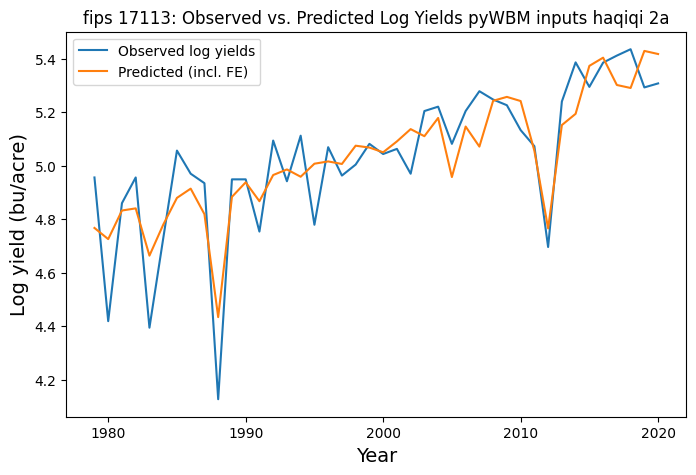

In [116]:
fips_number = '17113'
mclean_county_plot = predictions.loc[fips_number]
corn_yields = df_set_index.loc[fips_number, 'log_yield']

plt.figure(figsize=(8,5))
plt.plot(mclean_county_plot.index, corn_yields, label='Observed log yields')
plt.plot(mclean_county_plot.index, mclean_county_plot['total_pred'], label='Predicted (incl. FE)')
plt.title(f'fips {fips_number}: Observed vs. Predicted Log Yields pyWBM inputs haqiqi 2a')
plt.ylabel('Log yield (bu/acre)', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.legend()

/tmp/ipykernel_1104356/1427288412.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_year['log_yield'] = usda_pd_getlevel['log_yield']


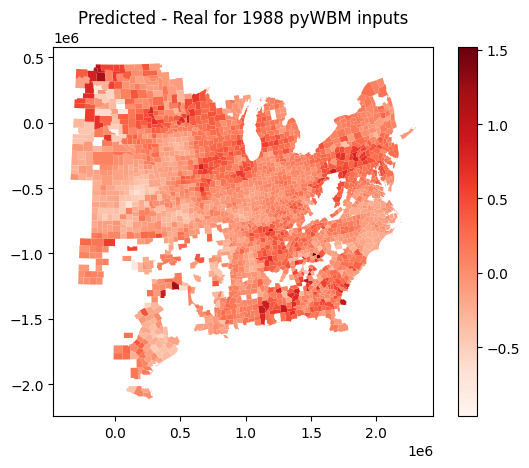

In [125]:
year_for_bias = 1988
df_year = predictions.xs(year_for_bias, level='year') 
usda_pd_fix = usda_pd.set_index(['year', 'fips'])
usda_pd_getlevel = usda_pd_fix.xs(year_for_bias, level='year') 
df_year['log_yield'] = usda_pd_getlevel['log_yield']

df_year = df_year.reset_index()

merged = counties.merge(df_year, on='fips', how='left')
merged['bias'] = merged['total_pred'] - merged['log_yield']
merged.plot(column='bias', cmap='Reds', legend=True)

plt.title(f'Predicted - Real for {year_for_bias} pyWBM inputs')
plt.show()

## Using pYWBM inputs for future distributions

In [21]:
csv_output_file = f"/storage/home/cta5244/work/pyWBM_yield_data/pyWBM_dday/"
# arbritrary path looks like /storage/home/cta5244/work/pyWBM_yield_data/pyWBM_dday/ACCESS-CM2_r1i1p1f1_ssp245_VIC_kge_2015-2044_ddaysm.csv 
all_patterns = sorted(glob.glob(f"{csv_output_file}*_ssp245_VIC_kge_2015-2044_ddaysm.csv"))

# get fixed effects from the intial model run (above) 
fixed_effects_by_fips = results_h21.estimated_effects
fixed_effects_no_time = fixed_effects_by_fips.reset_index(['fips', 'year']).drop('year', axis=1).drop_duplicates()
fixed_effects_no_time_unique = fixed_effects_no_time.drop_duplicates(subset='fips', keep='first')
fixed_effects_no_time_unique = fixed_effects_no_time_unique.set_index('fips')
valid_fips = df_set_index.index.get_level_values('fips').unique()

In [72]:
def futureYield(file_pattern_i):
    '''
    Given a file path of yearly aggregated regressors calculates future corn yield projections 
    This function must be ran after the model is trained on the historical period (as done above with haqiqi et al method)
    inputs
    - file_pattern_i which is the path to the file path we are interested in (this comes from script 6)
    outputs
    - pandas dataframe which includes fips and year as multi-index and prediction as column (of log corn yield)
    - pattern_name_i which is a cleaned pattern name corresponding to the future projections
    '''
    pattern_name = file_pattern_i.split("/")[-1]
    single_model = pd.read_csv(file_pattern_i)
    single_model['fips'] = single_model['fips'].astype(str).str.zfill(5)
    single_model['state'] = single_model['fips'].astype(str).str.slice(0, 2)
    single_model['year_input'] = single_model['year'].astype(float)
    single_model['year2'] = (single_model['year']**2).astype(float)
    single_model['SoilM_0_100cm_square'] = single_model['SoilM_0_100cm']**2
    # this is distinct and important to only retain valid states 
    single_model = single_model[single_model['fips'].isin(valid_fips)]
    single_model = single_model.set_index(['fips', 'year'])
    # we now go through each column multiplying it by its respective \beta_{i}
    new_predictions_no_effects = results_h21.predict(data=single_model, effects=True)
    new_predictions_no_effects = new_predictions_no_effects.reset_index('year')
    merged_df_predictions_fixed = pd.merge(new_predictions_no_effects, fixed_effects_no_time_unique, on='fips', how='inner')
    merged_df_predictions_fixed['total_pred'] = merged_df_predictions_fixed['predictions'] + merged_df_predictions_fixed['estimated_effects']
    merged_df_predictions_fixed = merged_df_predictions_fixed.reset_index()
    merged_df_predictions_fixed = merged_df_predictions_fixed.set_index(['fips', 'year'])
    return merged_df_predictions_fixed, pattern_name

def scalarYield(df_prediction_timespace, year, fips_code):
    '''
    Given df (like that of futureYield with fips, year, column), return the scalar corn yield for 
    certain combination of year and fips location
    '''
    return df_prediction_timespace.loc[fips_code, year]['total_pred'].item()

In [76]:
year = 2020
fips_code = '17113'
probability_dist_mclean_county, names_combination = [], []
for file_pattern_i in all_patterns:
    df_predictions_future, pattern_name = futureYield(file_pattern_i)
    scalar_corn_yield = scalarYield(df_predictions_future, year, fips_code)
    probability_dist_mclean_county.append(scalar_corn_yield)
    names_combination.append(pattern_name)

(array([1., 0., 0., 2., 3., 4., 3., 1., 3., 1.]),
 array([5.09832038, 5.13517586, 5.17203133, 5.2088868 , 5.24574227,
        5.28259775, 5.31945322, 5.35630869, 5.39316417, 5.43001964,
        5.46687511]),
 <BarContainer object of 10 artists>)

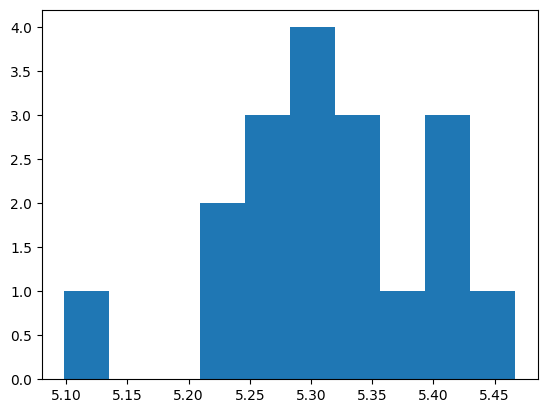

In [78]:
plt.hist(probability_dist_mclean_county)

## Exploratory Plotting

<Axes: >

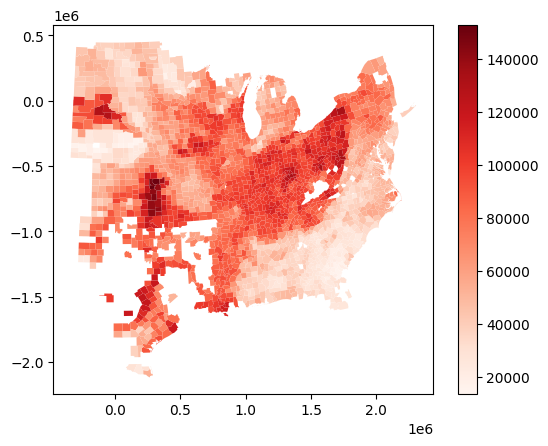

In [117]:
single_model_2020 = single_model.xs(2020, level='year')['SoilM_0_100cm_square']
usda_pd_fix = usda_pd.set_index(['year', 'fips'])
usda_pd_getlevel = usda_pd_fix.xs(2020, level='year') 

single_model_2020 = single_model_2020.reset_index()

merged = counties.merge(single_model_2020, on='fips', how='left')

merged.plot(column='SoilM_0_100cm_square', cmap='Reds', legend=True)